<a href="https://colab.research.google.com/github/Gorodecki/Projects/blob/master/ConvVAE_TF_Cat_Dog_Nekrasov.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Задание**
Возьмите любую базу достаточно простых изображений и сделайте генерацию с помощью CVAE. Добейтесь достаточно качественной генерации
Хороший вариант базы - фото собак и кошек (kaggle cats vs dogs)

https://www.kaggle.com/pocahontas1010/dogs-vs-cats-for-pytorch?


# Стартовый блок

In [ ]:
from IPython import display # очистка экрана

import glob # Модуль находит все пути, совпадающие с заданным шаблоном в соответствии с правилами, используемыми оболочкой Unix.
import matplotlib.pyplot as plt # вывод картинок на экран
import numpy as np # без этого никуда
import PIL # работа с изображениями
import tensorflow as tf # без комментариев
import tensorflow_probability as tfp # это доп. слои
import time # оценка времени работы сети
import zipfile # удобно распаковывать файлы

%matplotlib inline

In [ ]:
tfp.__version__

'0.10.0'

In [ ]:
tf.__version__

'2.2.0'

In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
path_to_zip = '/content/drive/My Drive/86422_199180_bundle_archive.zip'

In [ ]:
zzz = zipfile.ZipFile(path_to_zip, 'r')
zzz.extractall(path='/content/data/')

# Подготовка данных

In [ ]:
# картинки находятся в разных папках, разделены сразу на cats/dogs - train/test
BATCH_SIZE = 64 
IMG_WIDTH = 64
IMG_HEIGHT = 64
TRAIN_PATH = '/content/data/Cat_Dog_data/train/'
TEST_PATH = '/content/data/Cat_Dog_data/test/'

# присваиваем переменной - класс генератора
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1. / 255,

)
# Обучающая выборка
train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode=None,
    shuffle=True,
    seed=42,
    color_mode='rgb'
)

validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1. / 255 
)
# Проверочная выборка
validation_generator = validation_datagen.flow_from_directory(
    TEST_PATH,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode=None,
    shuffle=True,
    seed=42,
    color_mode='rgb'
)

Found 22500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


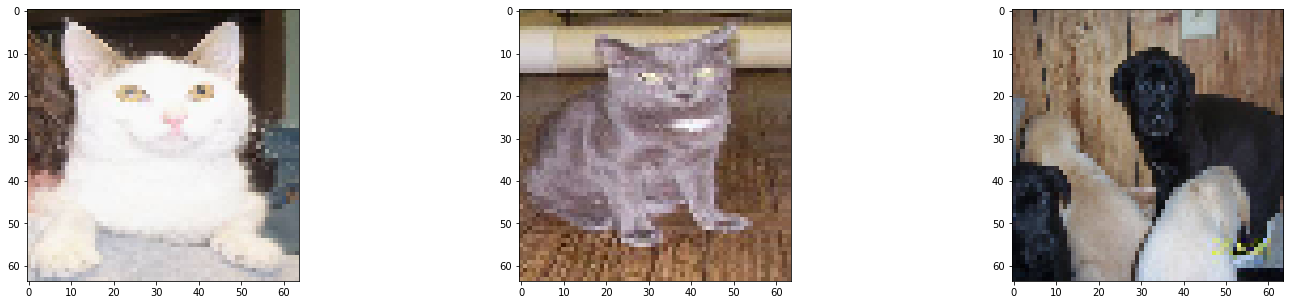

In [ ]:
#Выводим для примера картинки по каждому классу

fig, axs = plt.subplots(1, 3, figsize=(25, 5)) #Создаем полотно из 3 графиков
for i in range(3): #Проходим по всем классам
  axs[i].imshow(train_generator.next()[i])
plt.show() #Показываем изображения

# Нейросеть

In [ ]:
# теперь самое интересное, поскольку ООП в нейросетях - это хорошее умение. Пишем в этом ключе

class CVAE(tf.keras.Model): #наследует от класса Model
  """Сверточный вариативный автоэнкодер с подкреплением"""

  def __init__(self, latent_dim): # latent_dim
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(64, 64, 3)),              # вход в энкодер
            # tf.keras.layers.BatchNormalization(),  # не сработало
            tf.keras.layers.Conv2D(                                            # сверточный слой
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            # tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(                                             # сверточный слой
                filters=128, kernel_size=3, strides=(2, 2), activation='relu'),
            # tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(                                             # сверточный слой
                filters=512, kernel_size=3, strides=(2, 2), activation='relu'),
            # tf.keras.layers.BatchNormalization(),         
            tf.keras.layers.Flatten(),
            # Попробуем без активации, activation='relu'
            tf.keras.layers.Dense(latent_dim + latent_dim),                     # денс слой 
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=8*8*16, activation=tf.nn.relu),       # tf.nn.relu
            # tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Reshape(target_shape=(8, 8, 16)),
            tf.keras.layers.Conv2DTranspose(
                filters=512, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            # tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2DTranspose(
                filters=128, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            # tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            # tf.keras.layers.BatchNormalization(),
            # Опять же без активации
            tf.keras.layers.Conv2DTranspose(
                filters=3, kernel_size=3, strides=1, padding='same'),
        ]
    )
  @tf.function    # декоратор в тензорфлоу обрабатывающий быстро (параллелльно)
  
  # этой функцией создаем семплирование (нормальное распределение)
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)
  
  # энкодер
  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar
  
  # тот самый reparametrization trick
  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean
  
  # декодер
  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

In [ ]:
# теперь необходимо описать функцию ошибки (не забыть оптимайзер!!)

# не забыли
optimizer = tf.keras.optimizers.Adam(1e-4)

# функция как раз высчитывает расстояние Кульбака-Лейблера
def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)

# функция ошибки - самое непонятное место. Работа с тензорами требует навыка
def compute_loss(model, x):
  # вызываем модели 
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  # вот здесь вычисляем кросс-энтропию
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  # вычисляем суммарную среднюю ошибку
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)


# ускоренный подсчёт
@tf.function
def train_step(model, x, optimizer):
  """Рассчитываем один шаг и возвращаем ошибку
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

# Обучение нейросети

In [ ]:
# а теперь самое интересное, но всё получится!
epochs = 50
# внутреннее пространство
latent_dim = 256
# количество примеров для генерации
num_examples_to_generate = 16

# создаём рандомный вектор
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
# вот и дошли до создания модели
model = CVAE(latent_dim)

In [ ]:
# функция создания модели и отрисовки изображения
def generate_and_save_images(model, epoch, test_sample):
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(predictions[i, :, :, :]) #cmap='gray' если изображение ч\б
    plt.axis('off')

  # сохраняем картинку каждой эпохи (чтобы потом gif создать)
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [ ]:
# Берём примеры
assert BATCH_SIZE >= num_examples_to_generate
for test_batch in validation_generator[4]:  #test_dataset.take(1)
  test_sample = test_batch[0:num_examples_to_generate,:,:,:]

Epoch: 50, Test set ELBO: -7116.23046875, time elapse for current epoch: 49.13974094390869


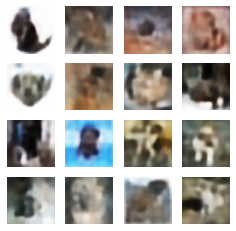

In [ ]:
generate_and_save_images(model, 0, test_sample)

for epoch in range(1, epochs + 1):
  start_time = time.time()
  for i in range(len(train_generator)): #len(train_generator)
    train_step(model, train_generator[i], optimizer)
    
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  for j in range(len(validation_generator)):
    loss(compute_loss(model, validation_generator[j]))
    print('.', end='')
  elbo = -loss.result()
  display.clear_output(wait=False)
  print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
  generate_and_save_images(model, epoch, test_sample)

# Результаты работы

In [ ]:
# создаём gif файл для презентации результата работы
import imageio
anim_file = '/content/drive/My Drive/cvae-3.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i, filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info >= (6, 2, 0, ''):
  display.Image(filename=anim_file)